## DeepHE Notebook

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn
from tqdm import tqdm
import timeit
import networkx as nx
from node2vec import Node2Vec
import pickle

### Retrieve data (PPI network, gene expression, gene effet)

In [2]:
# Retrieve Data

path = 'C:/Users/matth/Documents/Columbia/Courses/ML for Functional Genomics/Project/crispr-genomics/'

gene_expression = pd.read_csv(path + 'preprocess/gene_expression.csv').set_index('DepMap')
gene_effect = pd.read_csv(path + 'preprocess/gene_effect.csv').set_index('DepMap')
protein_info = pd.read_csv(path + 'preprocess/index_to_protein_and_gene.txt', header=None, sep=' ')
protein_info = protein_info.rename(columns={0:'index', 1:'protein', 2:'gene_ID'})
protein_info = protein_info.set_index('index')
index_links = pd.read_csv(path + "preprocess/index_links.csv")

In [3]:
# Create Dataset

indices = set(gene_effect.index).intersection(gene_expression.index)
indices = list(indices)
gene_effect_ = gene_effect[gene_effect.index.isin(indices)]
gene_expression_ = gene_expression[gene_expression.index.isin(indices)]
gene_expression_np = gene_expression_.to_numpy()
gene_effect_np = gene_effect_.to_numpy()
edge_index = index_links[['index1', 'index2']].to_numpy().T
edge_attr = index_links['combined_score'].to_numpy().reshape(-1,1)

In [4]:
# Retrieve the subgraph formed by nodes with index <= N_nodes

def rmv_useless_attr(edge_index, N_nodes ):
    
    idx_0 = set( np.where( edge_index[0] < N_nodes )[0] )
    idx_1 = set( np.where( edge_index[1] < N_nodes )[0] )
    idx = idx_0.intersection(idx_1)
    idx = list( idx )
    nodes_idx = set( np.hstack((edge_index[0, idx], edge_index[1, idx])).tolist() ) 
    edge_index_modif = edge_index[:, idx]
    edge_attr_modif = edge_attr[idx]
    
    return edge_index_modif, edge_attr_modif, nodes_idx, idx

N_nodes = 2000 # number of nodes to include in the subgraph
edge_index_, edge_attr_, nodes_idx, idx = rmv_useless_attr(edge_index, N_nodes )

In [5]:
# retrieve list of edges in appropriate format to create graph
w_edges = np.vstack( [ edge_index_, edge_attr_.reshape(1,-1) ] )
w_edges_list = [(w_edges[0,i], w_edges[1,i], w_edges[2,i]) for i in range(w_edges.shape[1])]

### Create graph and train node2vec model

In [6]:
# Create Graph
graph = nx.Graph()
graph.add_weighted_edges_from(w_edges_list)

In [7]:
# Precompute probabilities and generate walks - **ON WINDOWS ONLY WORKS WITH workers=1**
node2vec = Node2Vec(graph, dimensions=64, walk_length=10, num_walks=200, workers=1, temp_folder = 'temp/')  # Use temp_folder for big graphs
print("done.")

# Embed nodes
n2v_model = node2vec.fit(window=10, min_count=1, batch_words=4)  # Any keywords acceptable by gensim.Word2Vec can be passed, `dimensions` and `workers` are automatically passed (from the Node2Vec constructor)
print("done.")

# Save model for later use
n2v_model.save('data/n2v_model')

Computing transition probabilities:   0%|          | 0/1990 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 200/200 [01:06<00:00,  3.00it/s]


done.
done.


In [8]:
from gensim.models import Word2Vec

# Load model after Node2Vec.save
n2v_model = Word2Vec.load('data/n2v_model')

In [9]:
# contains representation of nodes listed in nodes_list
nodes_list = [int(n) for n in graph.nodes()]
emb_df = [n2v_model.wv.get_vector(str(n)) for n in graph.nodes()]

In [11]:
# Separate Essential (True) Genes from Non-Essential (False) for Regression

labels = gene_effect_np[0, nodes_list]

In [12]:
emb = np.stack(emb_df)
emb_labels =  np.hstack((emb, labels.reshape(-1,1)))

thd = 0 # threshold essential vs non-essential

ness_emb_labels = emb_labels[labels > thd]
ess_emb_labels = emb_labels[labels <= thd]

#ess_emb_labels = ess_emb_labels[:150] # keep a ratio ness/ess = 4

In [13]:
# WARNING: the order (essential/non-essential) is reversed with respect to the original code.

with open("data/ess_embedFeature.pickle", "wb") as f:
    pickle.dump(ness_emb_labels, f)
    
with open("data/ness_embedFeature.pickle", "wb") as f:
    pickle.dump(ess_emb_labels, f)

### Train the model

In [14]:
# training model

!python main.py --embedF 1 --result_dir results --repeat 1 --reg --numHiddenLayer 2 --fold 4

Iteration 0
(3233, 64)
(3233,)
(403, 64)
(403,)
Epoch 1/200

102/102 [==============================] - 2s 7ms/step - loss: 0.0902 - mse: 0.0902 - val_loss: 0.0880 - val_mse: 0.0880
Epoch 2/200

102/102 [==============================] - 1s 5ms/step - loss: 0.0673 - mse: 0.0673 - val_loss: 0.0639 - val_mse: 0.0639
Epoch 3/200

102/102 [==============================] - 0s 5ms/step - loss: 0.0506 - mse: 0.0506 - val_loss: 0.0528 - val_mse: 0.0528
Epoch 4/200

102/102 [==============================] - 1s 5ms/step - loss: 0.0422 - mse: 0.0422 - val_loss: 0.0460 - val_mse: 0.0460
Epoch 5/200

102/102 [==============================] - 1s 5ms/step - loss: 0.0352 - mse: 0.0352 - val_loss: 0.0409 - val_mse: 0.0409
Epoch 6/200

102/102 [==============================] - 1s 5ms/step - loss: 0.0380 - mse: 0.0380 - val_loss: 0.0440 - val_mse: 0.0440
Epoch 7/200

102/102 [==============================] - 1s 6ms/step - loss: 0.0316 - mse: 0.0316 - val_loss: 0.0353 - val_mse: 0.0353
Epoch 8/200

1

INFO: numexpr.utils - Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO: numexpr.utils - NumExpr defaulting to 8 threads.
INFO: DNN - results is already there.
INFO: DNN - results\model is already there.
INFO: ProcessDataset - essFeatTable has 808 rows and 65 columns.
INFO: ProcessDataset - nessTable has 3232 rows and 65 columns.
INFO: ProcessDataset - trainingData.shape=3233*65
INFO: ProcessDataset - validationData.shape=403*65
INFO: ProcessDataset - testingData.shape=404*65
INFO: ProcessDataset - trainData.shape=3233*65.
2022-12-20 04:43:32.894063: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-20 04:43:34.275113: I tensorflow/core/common_runtime/gpu/gpu_device.c

### Retrieve test performance

In [15]:
with open("results/_true_y_it0", "rb") as f:
    true_y = pickle.load(f)
with open("results/_probs_it0", "rb") as f:
    probs = pickle.load(f)

probs = probs[:,0]
#print(probs.shape)
true_y = np.array(true_y)
#print(true_y.shape)

In [16]:
def mse(x,y):
    return np.sum( np.square(x - y) ) / x.shape[0]

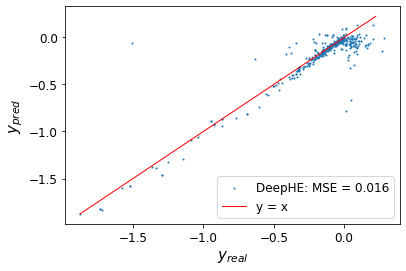

In [17]:
fig, ax = plt.subplots()
mse_ = mse(true_y, probs)
ax.scatter(true_y, probs, s = 1, label = "DeepHE: MSE = %.3f"%mse_)
min_ = np.min( np.hstack((true_y, probs)) )
max_ = np.max( np.hstack((true_y, probs)) )
x = np.arange(min_, max_, 0.1)
ax.plot(x, x, color = 'r', label = "y = x", linewidth = 1)
ax.set_ylabel("$y_{pred}$", fontsize = 15)
ax.set_xlabel("$y_{real}$", fontsize = 15)
#ax.text(-1.5, -0.5, "MSE = %.2f"%mse_)#, fontsize = 4)
ax.tick_params(axis = 'both', labelsize = 12)
ax.legend(fontsize= 12)

plt.savefig("imgs/results_deepHE_XXX.png", bbox_inches = 'tight')

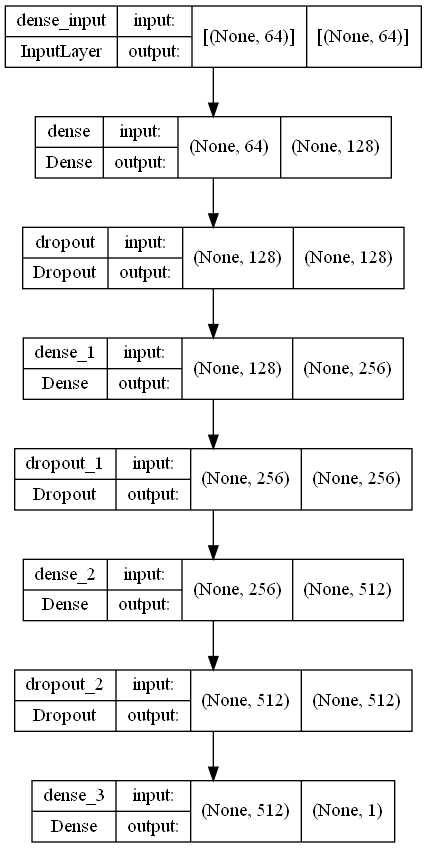

In [19]:
from tensorflow import keras
model = keras.models.load_model('results/model/Experiment0_weights.best.hdf5')

from keras.utils.vis_utils import plot_model
plot_model(model, to_file='imgs/model.png', show_shapes=True, show_layer_names=True)